In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

Using TensorFlow backend.


Set random seed for reproducibility.

In [2]:
np.random.seed(2020)
tf.set_random_seed(2020)

# Loading & Exploration

In [3]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

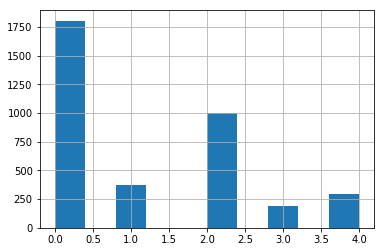

In [4]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

### Displaying some Sample Images

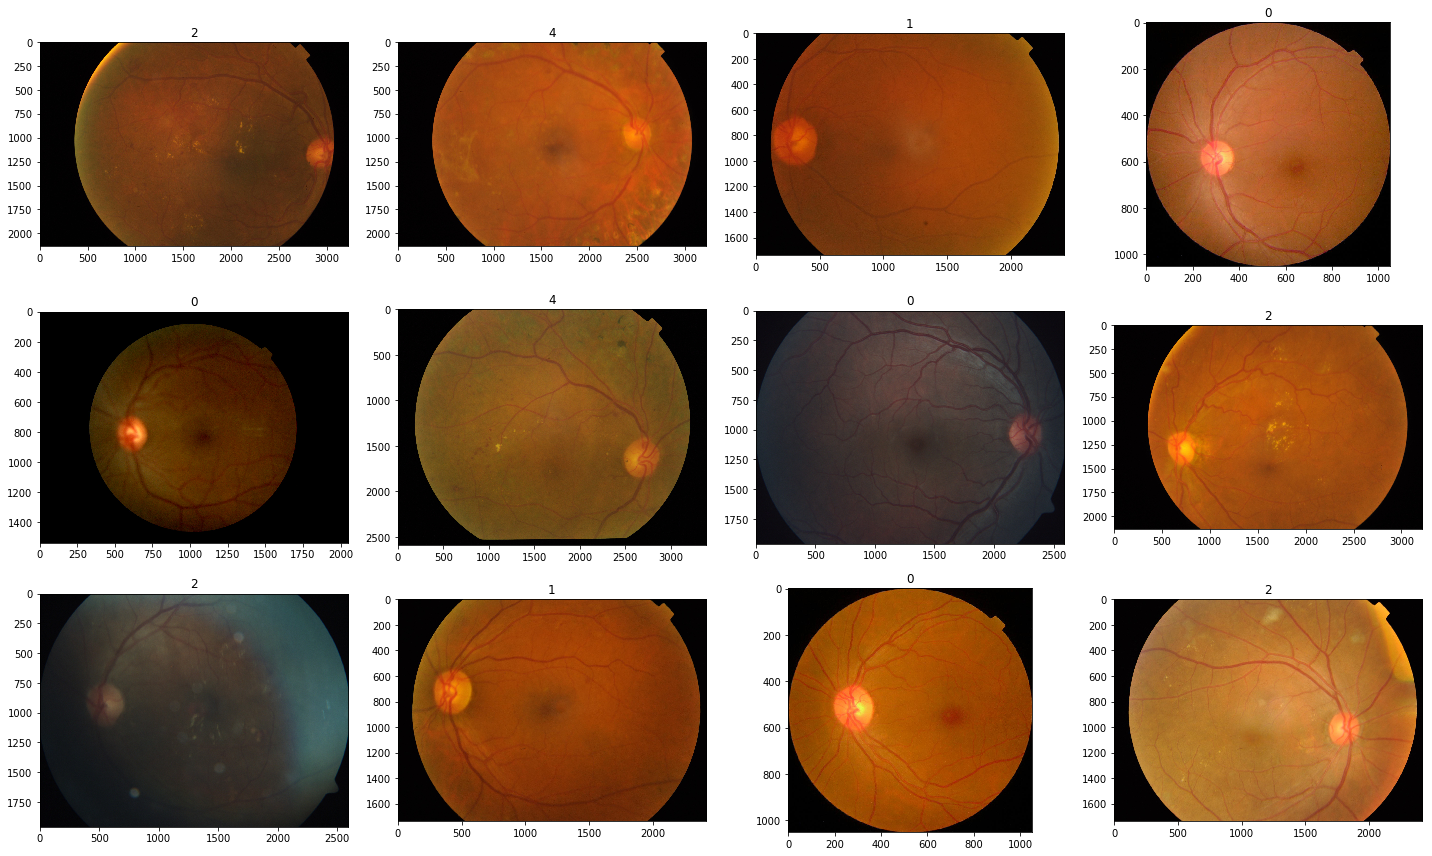

In [5]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Resize Images

We will resize the images to 456x456, then create a single numpy array to hold the data.

In [6]:
'''
# image height and image width ----> GLOBAL
img_ht = 456
img_wd = 456

def displayImage(display_name, image):
    cv2.namedWindow(display_name,cv2.WINDOW_AUTOSIZE)
    cv2.imshow(display_name, image)

def findContourEye(thresh_image):
    cnts = cv2.findContours(thresh_image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
#     cnts = imutils.grab_contours(cnts)
    cnts = max(cnts[0], key=cv2.contourArea)
    return cnts

def findContourEyeExtreme(cnts):
    # Locating extreme points on all 4 sides
    leftmost = tuple(cnts[cnts[:,:,0].argmin()][0])
    rightmost = tuple(cnts[cnts[:,:,0].argmax()][0])
    topmost = tuple(cnts[cnts[:,:,1].argmin()][0])
    bottommost = tuple(cnts[cnts[:,:,1].argmax()][0])
    # Locating the top left and bottom right corner
    x1 = leftmost[0]
    y1 = topmost[1]
    x2 = rightmost[0]
    y2 = bottommost[1]
    return x1,y1,x2,y2 

def findRadiusAndCentreOfContourEye(cnts):
    M = cv2.moments(cnts)
    if( M["m00"]==0):
        cX, cY = 0, 0
    else:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    if(cX < cY):
        r = cX
    else:
        r = cY
    return cX,cY,r

def drawCentreOnContourEye(image,cnts,cX,cY):
    cv2.drawContours(image, [cnts], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
    cv2.putText(image, "center", (cX - 20, cY - 20),
    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    return image
    
def Radius_Reduction(img,cX,cY,r):
    h,w,c=img.shape
    Frame=np.zeros((h,w,c),dtype=np.uint8)
    cv2.circle(Frame,(int(cX),int(cY)),int(r), (255,255,255), -1)
    Frame1=cv2.cvtColor(Frame, cv2.COLOR_BGR2GRAY)
    img1 =cv2.bitwise_and(img,img,mask=Frame1)
    return img1

def imageResize(image, ht, wd):
    # resized_image = imutils.resize(image, height = ht, width = wd)
    resized_image = cv2.resize(image,(wd,ht))
    return resized_image

def crop_black(image):
    org = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)[1]
    # displayImage('thresh',thresh)
    cnts = findContourEye(thresh)
    x1,y1,x2,y2 = findContourEyeExtreme(cnts)
    # print(x1,y1,x2,y2)
    crop = org[y1:y2, x1:x2]
    crop = imageResize(crop, img_ht, img_wd)
    # displayImage("cr1",crop)
    return crop

def imageAugmentation(image):
    x_flip = cv2.flip( image, 0 )
    y_flip = cv2.flip( image, 1 )
    xy_flip = cv2.flip(x_flip,1)
    return x_flip, y_flip, xy_flip

def imageHistEqualization(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    sub_med = cv2.addWeighted (im, 4, bg, -4, 255)
    return sub_med

def colorEnhancement(image1,image2):
    image_final = cv2.bitwise_and(image1,image2)
    return image_final

def imageAugSave(path,img1,img2,img3,img4,img_ht,img_wd):
    count = len(os.listdir(path))

    img1 = imageResize(img1, img_ht, img_wd)
    img2 = imageResize(img2, img_ht, img_wd)
    img3 = imageResize(img3, img_ht, img_wd)
    img4 = imageResize(img4, img_ht, img_wd)

    cv2.imwrite(os.path.join(path , '%d.png'%(count+1)), img1)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+2)), img2)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+3)), img3)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+4)), img4)
    return count+1,count+2,count+3,count+4

def processed_test_save(path,img,img_ht,img_wd):
    count = len(os.listdir(path))
    img = imageResize(img,img_ht,img_wd)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+1)), img)
    return count+1

'''

'\n# image height and image width ----> GLOBAL\nimg_ht = 456\nimg_wd = 456\n\ndef displayImage(display_name, image):\n    cv2.namedWindow(display_name,cv2.WINDOW_AUTOSIZE)\n    cv2.imshow(display_name, image)\n\ndef findContourEye(thresh_image):\n    cnts = cv2.findContours(thresh_image.copy(), cv2.RETR_EXTERNAL,\n\tcv2.CHAIN_APPROX_SIMPLE)\n#     cnts = imutils.grab_contours(cnts)\n    cnts = max(cnts[0], key=cv2.contourArea)\n    return cnts\n\ndef findContourEyeExtreme(cnts):\n    # Locating extreme points on all 4 sides\n    leftmost = tuple(cnts[cnts[:,:,0].argmin()][0])\n    rightmost = tuple(cnts[cnts[:,:,0].argmax()][0])\n    topmost = tuple(cnts[cnts[:,:,1].argmin()][0])\n    bottommost = tuple(cnts[cnts[:,:,1].argmax()][0])\n    # Locating the top left and bottom right corner\n    x1 = leftmost[0]\n    y1 = topmost[1]\n    x2 = rightmost[0]\n    y2 = bottommost[1]\n    return x1,y1,x2,y2 \n\ndef findRadiusAndCentreOfContourEye(cnts):\n    M = cv2.moments(cnts)\n    if( M["m00

In [7]:
'''
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image_YY(image_path, desired_size=456):
    image = cv2.imread(image_path)
    image = imageResize(image, desired_size, desired_size)
    image_crop = crop_black(image)
    image_clahe = imageHistEqualization(image_crop)
    sub_med = subtract_median_bg_image(image_clahe)
    image_final = colorEnhancement(sub_med, image_clahe)
    return image_final
'''
# image height and image width ----> GLOBAL
img_ht = 300
img_wd = 300

def preprocess_image(image_path, desired_size=300):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [8]:
N = train_df.shape[0]
x_train = np.empty((N, img_ht, img_wd, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

In [9]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)

(3662, 300, 300, 3)
(3662, 5)


## Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [10]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


Now we can split it into a training and validation set.

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2020
)

#  Data Generator

In [12]:
BATCH_SIZE = 4

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        width_shift_range = 0.3,
        height_shift_range=0.3
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2020)

### Creating keras callback for QWK

In [13]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('effnet_b1.h5')

        return

# Model: DenseNet-121

In [14]:
# densenet = DenseNet121(
#     weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
#     include_top=False,
#     input_shape=(224,224,3)
# )

# Efficienetnet

In [15]:
import gc
gc.collect()
import os
import sys
# Repository source: https://github.com/qubvel/efficientnet
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import EfficientNetB3
# Load in EfficientNetB3
effnet = EfficientNetB3(weights=None,
                        include_top=False,
                        input_shape=(img_wd, img_ht, 3))
effnet.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b3_imagenet_1000_notop.h5')

In [16]:
def build_model():
    model = Sequential()
    model.add(effnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [17]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
Total params: 10,791,213
Trainable params: 10,703,917
Non-trainable params: 87,296
_________________________________________________________________


# Training & Evaluation

In [18]:
es = EarlyStopping(monitor='val_loss',
                                      mode='auto',
                                      verbose=1,
                                      patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            mode = 'auto',
                                            factor=0.25,
                                            min_lr=0.000001)


In [19]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics,es, learning_rate_reduction]
)

Epoch 1/25
778/778 [==============================] - 232s 298ms/step - loss: 0.3104 - acc: 0.8801 - val_loss: 0.1535 - val_acc: 0.9411
val_kappa: 0.8588
Validation Kappa has improved. Saving model.
Epoch 2/25
778/778 [==============================] - 198s 255ms/step - loss: 0.2071 - acc: 0.9195 - val_loss: 0.1240 - val_acc: 0.9491
val_kappa: 0.8845
Validation Kappa has improved. Saving model.
Epoch 3/25
778/778 [==============================] - 200s 258ms/step - loss: 0.1854 - acc: 0.9276 - val_loss: 0.1129 - val_acc: 0.9542
val_kappa: 0.8978
Validation Kappa has improved. Saving model.
Epoch 4/25
778/778 [==============================] - 199s 256ms/step - loss: 0.1672 - acc: 0.9337 - val_loss: 0.1186 - val_acc: 0.9491
val_kappa: 0.8957
Epoch 5/25
778/778 [==============================] - 195s 251ms/step - loss: 0.1453 - acc: 0.9425 - val_loss: 0.1082 - val_acc: 0.9571
val_kappa: 0.9046
Validation Kappa has improved. Saving model.
Epoch 6/25
778/778 [==============================

In [20]:
with open('history.json', 'w') as f:
    try:
        json.dump(history.history, f)
    except:
        pass



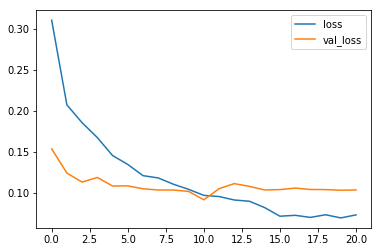

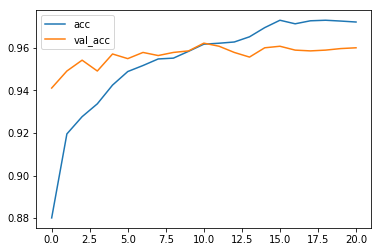

In [21]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

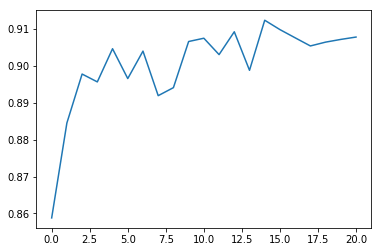

In [22]:
plt.plot(kappa_metrics.val_kappas)